# Analysis of super spreader events

This analysis follows the paper ["An open-access database of infectious disease transmission trees to explore superspreader epidemiology"](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001685), whose R code is available below:

https://github.com/DrakeLab/taube-transmission-trees

This study looked a transmission trees from many outbreaks (Zika, Ebola, measles, SARS-CoV-2, etc.) reported in the literature, and using these trees, exlored questions about superspreader epidemiology, such as what dispersion parameters cause the highest proportion of cases causing superspreading events, and how superspreaders are infected (e.g., mostly by other superspreaders.

Their results are catalogued and made available through the following site:

https://outbreaktrees.ecology.uga.edu/

In [1]:
import os
from os import path
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.stats import poisson

from utils.superspreader import inf_by_ss_info, gen_halves_stats, extract_ss_info_all, fit_nbinom, get_nbinom_size

In [2]:
data_folder = "./data"
output_folder = "./output"
if not path.exists(output_folder):
    os.makedirs(output_folder)

The analysis assumes a single tree, so we keep the largest connected component subgraph:

In [3]:
# Set a random seed for reproducibility
random_seed = 32
random.seed(random_seed)

with open(path.join(data_folder, 'transmission-tree.pickle'), 'rb') as f:
    T = pickle.load(f)
    
components = nx.weakly_connected_components(T)

subgraphs = [T.subgraph(c) for c in components]
for sg in subgraphs:
    print(len(sg.nodes()), len(sg.edges()))

# Calculate the largest connected component subgraph:
T = sorted(subgraphs, key=lambda x: len(x))[-1]

262 261
40 39
18 17
7 6
2 1


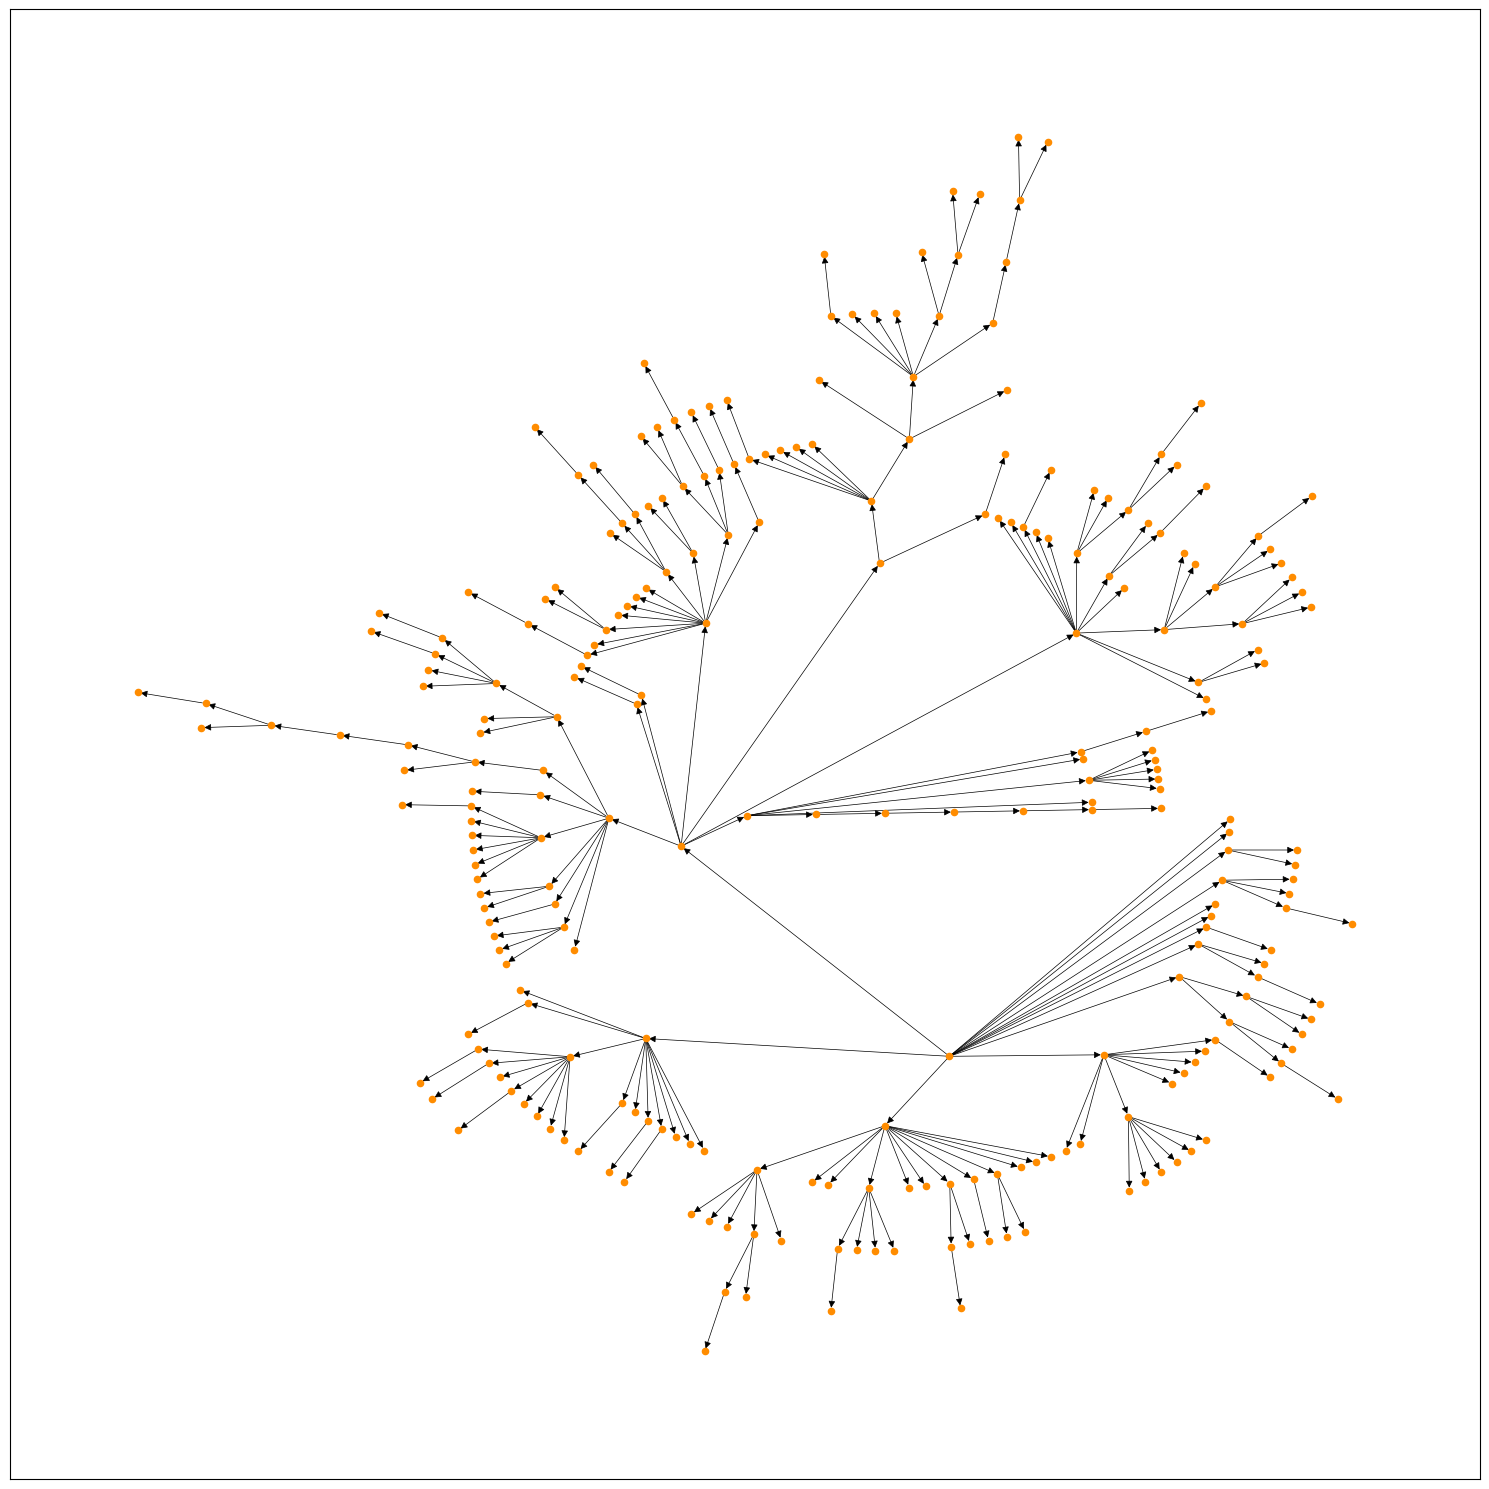

In [4]:
# program = 'dot'    # It arranges nodes hierarchically, often producing a tree-like or layered structure
# program = 'neato'  # Neato attempts to minimize a global energy function, which tends to spread the graph out evenly
# program = 'fdp'    # fdp is a force-directed layout algorithm that simulates physical forces acting on the nodes
# program = 'sfdp'   # sfdp is an extension of fdp designed to handle large graphs by using a multiscale approach
program = 'twopi' # twopi arranges nodes in concentric circles, with edges drawn as spokes connecting the circles
# program ='circo'   # circo arranges nodes in a circular layout, with edges drawn as arcs

pos = nx.nx_agraph.graphviz_layout(T, prog=program)
plt.figure(figsize=(15, 15))
nx.draw_networkx(T, pos, with_labels=False, node_color='darkorange', node_size=20, width=0.5, alpha=1)
plt.tight_layout()
plt.savefig(path.join(output_folder, 'transmission-tree.png'))
plt.show()

In [5]:
out_degrees = dict(T.out_degree())
root_nodes = [node for node, in_degree in T.in_degree() if in_degree == 0]
noterm_nodes = [node for node, out_degree in T.out_degree() if out_degree > 0]
noterm_degrees = dict(T.out_degree(noterm_nodes))

d = list(out_degrees.values()) # Out degree of all nodes
d_noterm = list(noterm_degrees.values()) # Out degree of nodes that are not terminal

R0_all = np.mean(d)
R0_noterm = np.mean(d_noterm)

print("R0 for all nodes", R0_all)
print("R0 with no terminal nodes", R0_noterm)

R0 for all nodes 0.9961832061068703
R0 with no terminal nodes 2.5588235294117645


In [6]:
# Determine the maximum distance to all vertices from the roots
R0_nolastgen = 0

# Out-degree of vertices not in the last generation
d_nolastgen = []

for root in root_nodes:
    gens = nx.single_source_shortest_path_length(T, root)

    # Exclude vertices in the last generation
    not_last_gen = [node for node, dist in gens.items() if dist < np.max(list(gens.values()))]

    # Calculate the out-degree of vertices not in the last generation
    d_nolastgen = [T.out_degree(node) for node in not_last_gen]

    # Calculate the mean out-degree of vertices not in the last generation
    R0_nolastgen += sum(d_nolastgen) / len(d_nolastgen)

print("R0 with no last generation nodes", R0_nolastgen)

R0 with no last generation nodes 1.0077220077220077


In [7]:
# calculate coefficient of variance, tree size

# Calculate the mean out-degree
mean_out_degree = sum(d for n, d in T.out_degree()) / T.number_of_nodes()

# Calculate the variance of out-degrees
out_degrees = [d for n, d in T.out_degree()]
var_out_degree = sum((d - mean_out_degree) ** 2 for d in out_degrees) / len(out_degrees)

# Calculate the coefficient of variation
tree_cv = mean_out_degree / var_out_degree
tree_sz = T.number_of_nodes()

print("Coefficient of Variation:", tree_cv)
print("Number of nodes:", tree_sz)

Coefficient of Variation: 0.23282862503021773
Number of nodes: 262


In [8]:
dp = get_nbinom_size(fit_nbinom(d))
dp_noterm = get_nbinom_size(fit_nbinom(d_noterm))
dp_nolastgen = get_nbinom_size(fit_nbinom(d_nolastgen))

# If you want to visually chekc the fit use the following
#plot_nbinom_fit(d_nolastgen, fit_nbinom(d_nolastgen))

Optimization terminated successfully.
         Current function value: 1.316952
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.027381
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.326642
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11


In [9]:
for root in root_nodes:
    # calculate r0 and dp for generations 0 and 1 for trees with 20+ nodes and 2+ generations of spread    
    gen1 = T.out_degree(root)
    prop_gen1 = gen1/tree_sz

    # Initialize variables
    r0_takeoff = r0_takeoff_noterm = dp_takeoff = dp_takeoff_noterm = np.nan

    # Calculate first generation node degrees
    first_gen_nodes = [node for node, dist in nx.single_source_shortest_path_length(T, root).items() if dist == 1]
    first_gen_degs = [T.out_degree(node) for node in first_gen_nodes]
    first_gen_degs_nt = [deg for deg in first_gen_degs if deg > 0]

    # Calculate r0_takeoff
    r0_takeoff = (gen1 + sum(first_gen_degs)) / (gen1 + 1)

    # Calculate r0_takeoff_noterm
    r0_takeoff_noterm = (gen1 + sum(first_gen_degs_nt)) / (len(first_gen_degs_nt) + 1)

    # Concatenate degrees for fitting
    degrees_all = [gen1] + first_gen_degs
    degrees_nt = [gen1] + first_gen_degs_nt

    print(degrees_all)
    print(degrees_nt)
    
    # Fit negative binomial distribution to degrees
    dp_takeoff = get_nbinom_size(fit_nbinom(degrees_all))
    dp_takeoff_noterm = get_nbinom_size(fit_nbinom(degrees_nt))

    # Calculate thresholds
    thresh = poisson.ppf(0.99, R0_all)  # threshold for root node
    thresh_noterm = poisson.ppf(0.99, R0_noterm)  # threshold for non-terminal nodes
    thresh_nolastterm = poisson.ppf(0.99, R0_nolastgen)  # threshold for non-terminal nodes excluding last generation
    thresh_g01 = poisson.ppf(0.99, r0_takeoff)  # threshold for first generation nodes
    thresh_g01_noterm = poisson.ppf(0.99, r0_takeoff_noterm)  # threshold for non-terminal first generation nodes

    # Count number of second generation nodes that exceed the threshold
    num_ss = len([node for node, deg in T.out_degree() if deg > thresh])
    num_ss_noterm = len([node for node, deg in T.out_degree() if deg > thresh_noterm])
    num_ss_nolastterm = len([node for node, deg in T.out_degree() if deg > thresh_nolastterm])
    num_ss_g01 = len([node for node, deg in T.out_degree() if deg > thresh_g01])
    num_ss_g01_noterm = len([node for node, deg in T.out_degree() if deg > thresh_g01_noterm])
    prop_ss = num_ss/tree_sz

[13, 12, 7, 8, 2, 2, 1, 0, 0, 3, 2, 10, 0, 0]
[13, 12, 7, 8, 2, 2, 1, 3, 2, 10]
Optimization terminated successfully.
         Current function value: 2.544904
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.769658
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


In [10]:
ss_data_list = extract_ss_info_all(T, thresh)
ss_data_list_noterm = extract_ss_info_all(T, thresh_noterm)
ss_data_list_nolastterm = extract_ss_info_all(T, thresh_nolastterm)
ss_data_list_g01 = extract_ss_info_all(T, num_ss_g01)
ss_data_list_g01_noterm = extract_ss_info_all(T, num_ss_g01_noterm)

inf_by_ss_data_list_all = inf_by_ss_info(T, thresh, thresh_noterm, thresh_nolastterm, num_ss_g01, num_ss_g01_noterm)
gen_halves_analysis = gen_halves_stats(T, thresh)

Optimization terminated successfully.
         Current function value: 1.405117
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.116643
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.936112
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: 1.378832
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: 1.405117
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 2.116643
         Iterations: 6
         Function evaluations: 7
       

In [11]:
gen_halves_list = gen_halves_analysis['summary']
gen_halves_full_sims_list = gen_halves_analysis['indiv_sims']
gen_halves_list

,Gens,R_1,R_2,DP_1,DP_2,SS Freq 1,SS Freq 2,R_1_NT,R_2_NT,DP_1_NT,DP_2_NT,SS Freq 1 NT,SS Freq 2 NT,rep_num
0,9.0,1.148515,0.483333,0.349796,0.912619,0.074257,0.016667,2.829268,1.45,2.426263,100.0,0.039604,0.016667,4.5


In [12]:
print('RESULTS FOR ALL NODES')
print(f"R 1st half = {gen_halves_list['R_1'][0]:.2f}")
print(f"R 2nd half = {gen_halves_list['R_2'][0]:.2f}")
print(f"k 1st half = {gen_halves_list['DP_1'][0]:.2f}")
print(f"k 2nd half = {gen_halves_list['DP_2'][0]:.2f}")
print(f"Percentage of cases causing SS in 1st half = {100 * gen_halves_list['SS Freq 1'][0]:.2f}%")
print(f"Percentage of cases causing SS in 2nd half = {100 * gen_halves_list['SS Freq 2'][0]:.2f}%")
print(f"Observed number of SS dyads = {round(inf_by_ss_data_list_all['all_nodes']['Obs SS Dyads'])}")
print(f"Expected number of SS dyads = {inf_by_ss_data_list_all['all_nodes']['Exp SS Dyads']:.2f}")
ratio = inf_by_ss_data_list_all['all_nodes']['Obs SS Dyads'] / inf_by_ss_data_list_all['all_nodes']['Exp SS Dyads']
print(f"Ratio of observed to expected SS dyads = {ratio:.2f}")

RESULTS FOR ALL NODES
R 1st half = 1.15
R 2nd half = 0.48
k 1st half = 0.35
k 2nd half = 0.91
Percentage of cases causing SS in 1st half = 7.43%
Percentage of cases causing SS in 2nd half = 1.67%
Observed number of SS dyads = 13
Expected number of SS dyads = 0.92
Ratio of observed to expected SS dyads = 14.19


In [13]:
print('RESULTS WITH NO TERMINAL NODES')
print(f"R 1st half = {gen_halves_list['R_1_NT'][0]:.2f}")
print(f"R 2nd half = {gen_halves_list['R_2_NT'][0]:.2f}")
print(f"k 1st half = {gen_halves_list['DP_1_NT'][0]:.2f}")
print(f"k 2nd half = {gen_halves_list['DP_2_NT'][0]:.2f}")
print(f"Percentage of cases causing SS in 1st half = {100 * gen_halves_list['SS Freq 1 NT'][0]:.2f}%")
print(f"Percentage of cases causing SS in 2nd half = {100 * gen_halves_list['SS Freq 2 NT'][0]:.2f}%")
print(f"Observed number of SS dyads = {inf_by_ss_data_list_all['noterm_nodes']['Obs SS Dyads']}")
print(f"Expected number of SS dyads = {inf_by_ss_data_list_all['noterm_nodes']['Exp SS Dyads']:.2f}")
ratio = inf_by_ss_data_list_all['noterm_nodes']['Obs SS Dyads'] / inf_by_ss_data_list_all['noterm_nodes']['Exp SS Dyads']
print(f"Ratio of observed to expected SS dyads = {ratio:.2f}")

RESULTS WITH NO TERMINAL NODES
R 1st half = 2.83
R 2nd half = 1.45
k 1st half = 2.43
k 2nd half = 100.00
Percentage of cases causing SS in 1st half = 3.96%
Percentage of cases causing SS in 2nd half = 1.67%
Observed number of SS dyads = 4
Expected number of SS dyads = 0.21
Ratio of observed to expected SS dyads = 18.71
